# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [2]:
# Import libraries

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline  # Only for Jupyter Notebooks

# Date and time handling
from datetime import datetime

# Preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# System and warnings
import os
import warnings
import glob
warnings.filterwarnings("ignore")


UsageError: unrecognized arguments: # Only for Jupyter Notebooks


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [126]:
# Define a function to load data and aggregate them

import pandas as pd
import os

def load_and_aggregate_stock_data(file_list):   
    combined_df = None

    for file_path in file_list:        
        stock_symbol = os.path.basename(file_path).split('_')[0]
        df = pd.read_csv(file_path)
        
        # Convert Date column to datetime
        df['Date'] = pd.to_datetime(df['Date'])
        
        # Drop 'Name' column if it exists (since we already extracted the symbol)
        if 'Name' in df.columns:
            df = df.drop(columns=['Name'])
        
        # Rename columns to prefix with stock symbol (except 'Date')
        df = df.rename(columns={col: f"{stock_symbol}_{col}" for col in df.columns if col != 'Date'})
        
        # Merge with combined_df on 'Date'
        if combined_df is None:
            combined_df = df
        else:
            combined_df = pd.merge(combined_df, df, on='Date', how='inner')

    return combined_df


In [6]:
import glob

# List all CSV files inside the RNN_Stocks_Data folder
file_list = glob.glob("RNN_Stocks_Data/*.csv")

# Load and combine the data
aggregated_df = load_and_aggregate_stock_data(file_list)

# Preview the combined DataFrame
print(aggregated_df.head())

        Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58      7582127   
1 2006-01-04      47.48      47.73     46.69       47.25      7440914   
2 2006-01-05      47.16      48.20     47.11       47.65      5417258   
3 2006-01-06      47.97      48.58     47.32       47.87      6154285   
4 2006-01-09      46.55      47.10     46.40       47.08      8945056   

   IBM_Open  IBM_High  IBM_Low  IBM_Close  ...  MSFT_Open  MSFT_High  \
0     82.45     82.55    80.81      82.06  ...      26.25      27.00   
1     82.20     82.50    81.33      81.95  ...      26.77      27.08   
2     81.40     82.90    81.00      82.50  ...      26.96      27.13   
3     83.95     85.03    83.41      84.95  ...      26.89      27.00   
4     84.10     84.25    83.38      83.73  ...      26.93      27.07   

   MSFT_Low  MSFT_Close  MSFT_Volume  GOOGL_Open  GOOGL_High  GOOGL_Low  \
0     26.10       26.84     79974418      211.47     

In [8]:
# View specifics of the data

# Check the shape of the DataFrame
print("Shape:", aggregated_df.shape)

# View column names
print("Columns:", aggregated_df.columns.tolist())

# View data types and nulls
aggregated_df.info()

# View first few rows
aggregated_df.head()


Shape: (3019, 21)
Columns: ['Date', 'AMZN_Open', 'AMZN_High', 'AMZN_Low', 'AMZN_Close', 'AMZN_Volume', 'IBM_Open', 'IBM_High', 'IBM_Low', 'IBM_Close', 'IBM_Volume', 'MSFT_Open', 'MSFT_High', 'MSFT_Low', 'MSFT_Close', 'MSFT_Volume', 'GOOGL_Open', 'GOOGL_High', 'GOOGL_Low', 'GOOGL_Close', 'GOOGL_Volume']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          3019 non-null   datetime64[ns]
 1   AMZN_Open     3019 non-null   float64       
 2   AMZN_High     3019 non-null   float64       
 3   AMZN_Low      3019 non-null   float64       
 4   AMZN_Close    3019 non-null   float64       
 5   AMZN_Volume   3019 non-null   int64         
 6   IBM_Open      3018 non-null   float64       
 7   IBM_High      3019 non-null   float64       
 8   IBM_Low       3018 non-null   float64       
 9   IBM_Close     3019 non-null   floa

Date  AMZN_Open  AMZN_High  AMZN_Low  AMZN_Close  AMZN_Volume  \
0 2006-01-03      47.47      47.85     46.25       47.58      7582127   
1 2006-01-04      47.48      47.73     46.69       47.25      7440914   
2 2006-01-05      47.16      48.20     47.11       47.65      5417258   
3 2006-01-06      47.97      48.58     47.32       47.87      6154285   
4 2006-01-09      46.55      47.10     46.40       47.08      8945056   

   IBM_Open  IBM_High  IBM_Low  IBM_Close  ...  MSFT_Open  MSFT_High  \
0     82.45     82.55    80.81      82.06  ...      26.25      27.00   
1     82.20     82.50    81.33      81.95  ...      26.77      27.08   
2     81.40     82.90    81.00      82.50  ...      26.96      27.13   
3     83.95     85.03    83.41      84.95  ...      26.89      27.00   
4     84.10     84.25    83.38      83.73  ...      26.93      27.07   

   MSFT_Low  MSFT_Close  MSFT_Volume  GOOGL_Open  GOOGL_High  GOOGL_Low  \
0     26.10       26.84     79974418      211.47      218.05     209.32   
1     26.77       26.97     57975661      222.17      224.70     220.09   
2     26.91       26.99     48247610      223.22      226.00     220.97   
3     26.49       26.91    100969092      228.66      235.49     226.85   
4     26.76       26.86     55627836      233.44      236.94     230.70   

   GOOGL_Close  GOOGL_Volume  
0       217.83      13137450  
1       222.84      15292353  
2       225.85      10815661  
3       233.06      17759521  
4       233.68      12795837  

[5 rows x 21 columns]

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [12]:
# Handle Missing Values

# Count of missing values per column
print(aggregated_df.isnull().sum())

# Ensure the DataFrame is sorted by Date
aggregated_df = aggregated_df.sort_values("Date")

# Forward fill
aggregated_df = aggregated_df.ffill()

# Backward fill (for any remaining missing values at the start)
aggregated_df = aggregated_df.bfill()

print("Remaining missing values:", aggregated_df.isnull().sum().sum())


Date            0
AMZN_Open       0
AMZN_High       0
AMZN_Low        0
AMZN_Close      0
AMZN_Volume     0
IBM_Open        0
IBM_High        0
IBM_Low         0
IBM_Close       0
IBM_Volume      0
MSFT_Open       0
MSFT_High       0
MSFT_Low        0
MSFT_Close      0
MSFT_Volume     0
GOOGL_Open      0
GOOGL_High      0
GOOGL_Low       0
GOOGL_Close     0
GOOGL_Volume    0
dtype: int64
Remaining missing values: 0


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

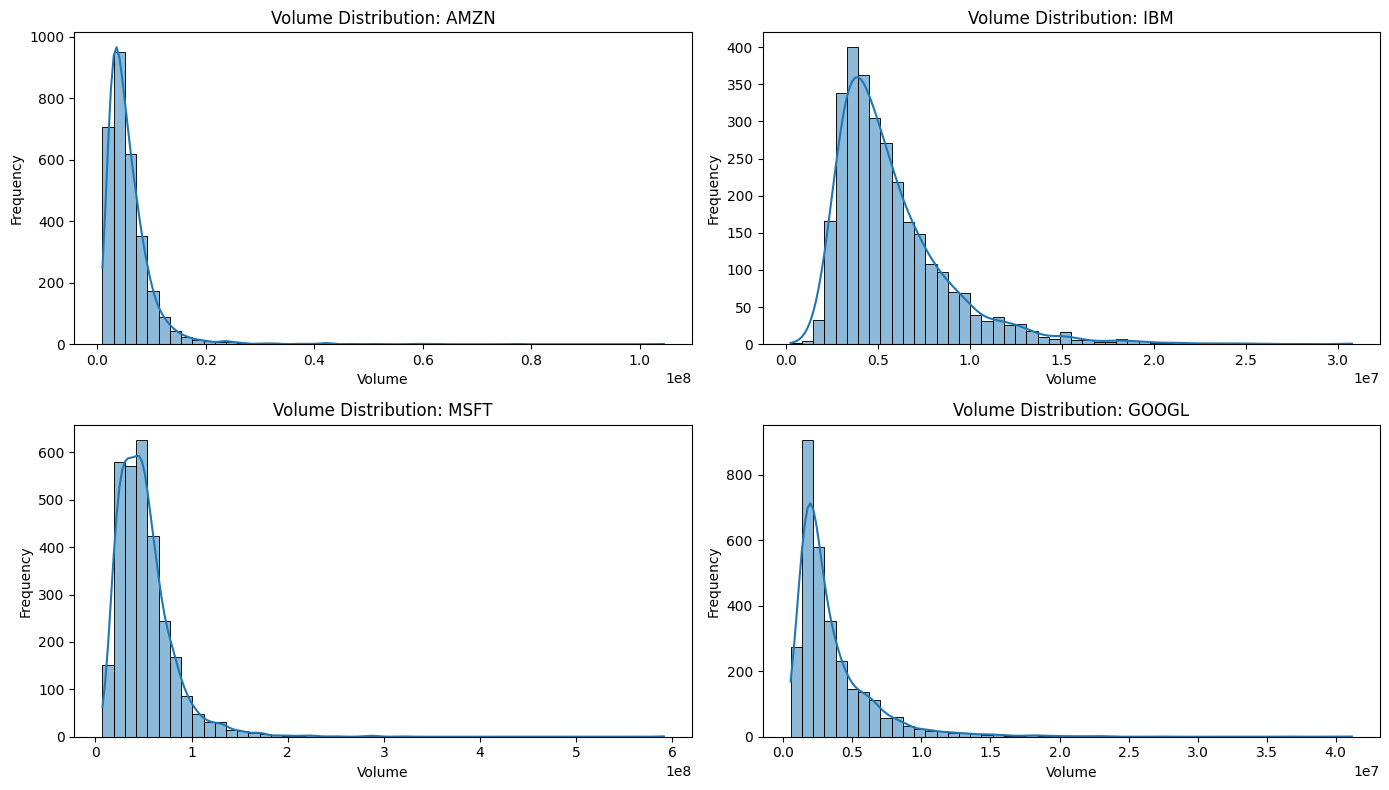

In [13]:
# Frequency distribution of volumes

import matplotlib.pyplot as plt
import seaborn as sns

volume_cols = [col for col in aggregated_df.columns if col.endswith('_Volume')]

plt.figure(figsize=(14, 8))

for i, col in enumerate(volume_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(aggregated_df[col], bins=50, kde=True)
    plt.title(f'Volume Distribution: {col.replace("_Volume", "")}')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


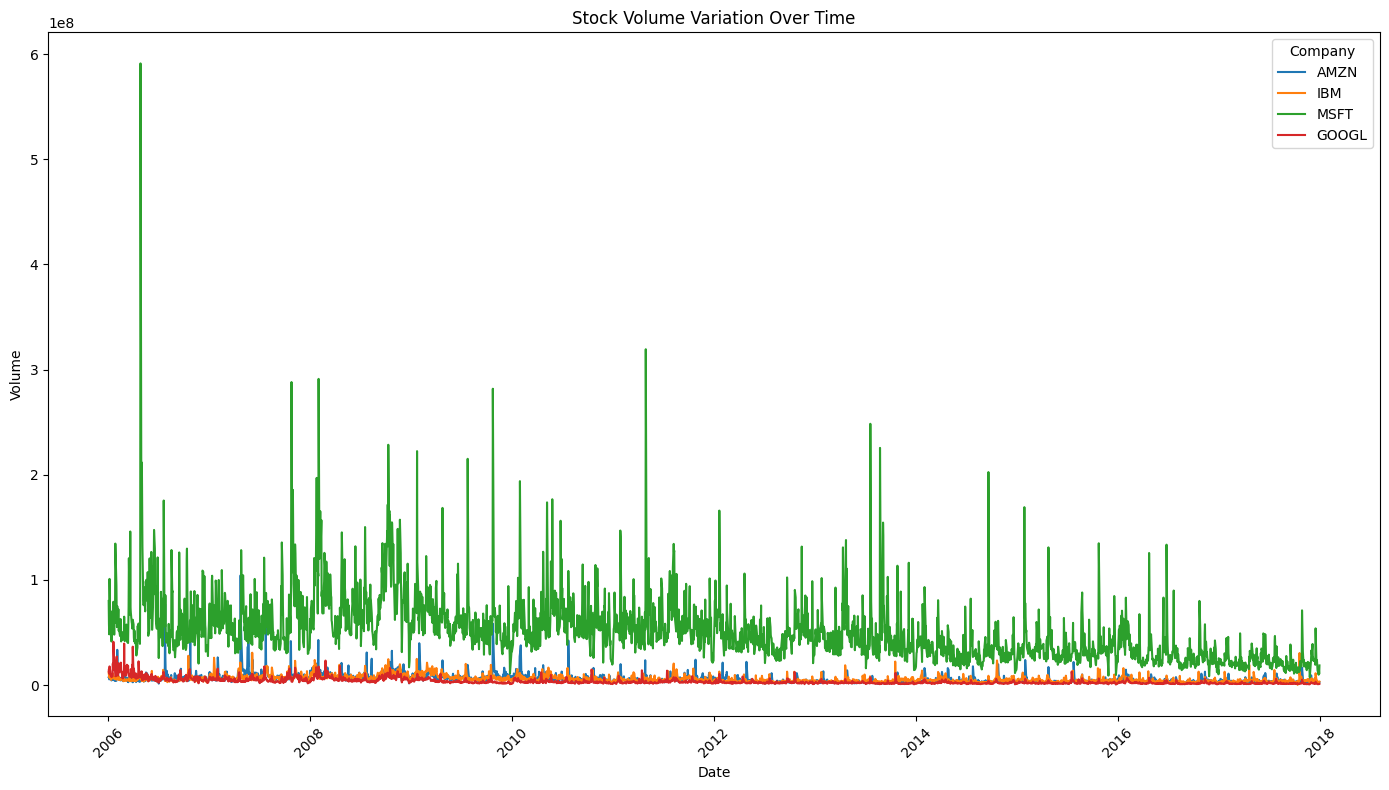

In [14]:
# Stock volume variation over time

# Select volume columns (e.g., 'AMZN_Volume', 'GOOGL_Volume', etc.)
volume_cols = [col for col in aggregated_df.columns if col.endswith('_Volume')]

plt.figure(figsize=(14, 8))

for col in volume_cols:
    sns.lineplot(data=aggregated_df, x='Date', y=col, label=col.replace('_Volume', ''))

plt.title('Stock Volume Variation Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(title='Company')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

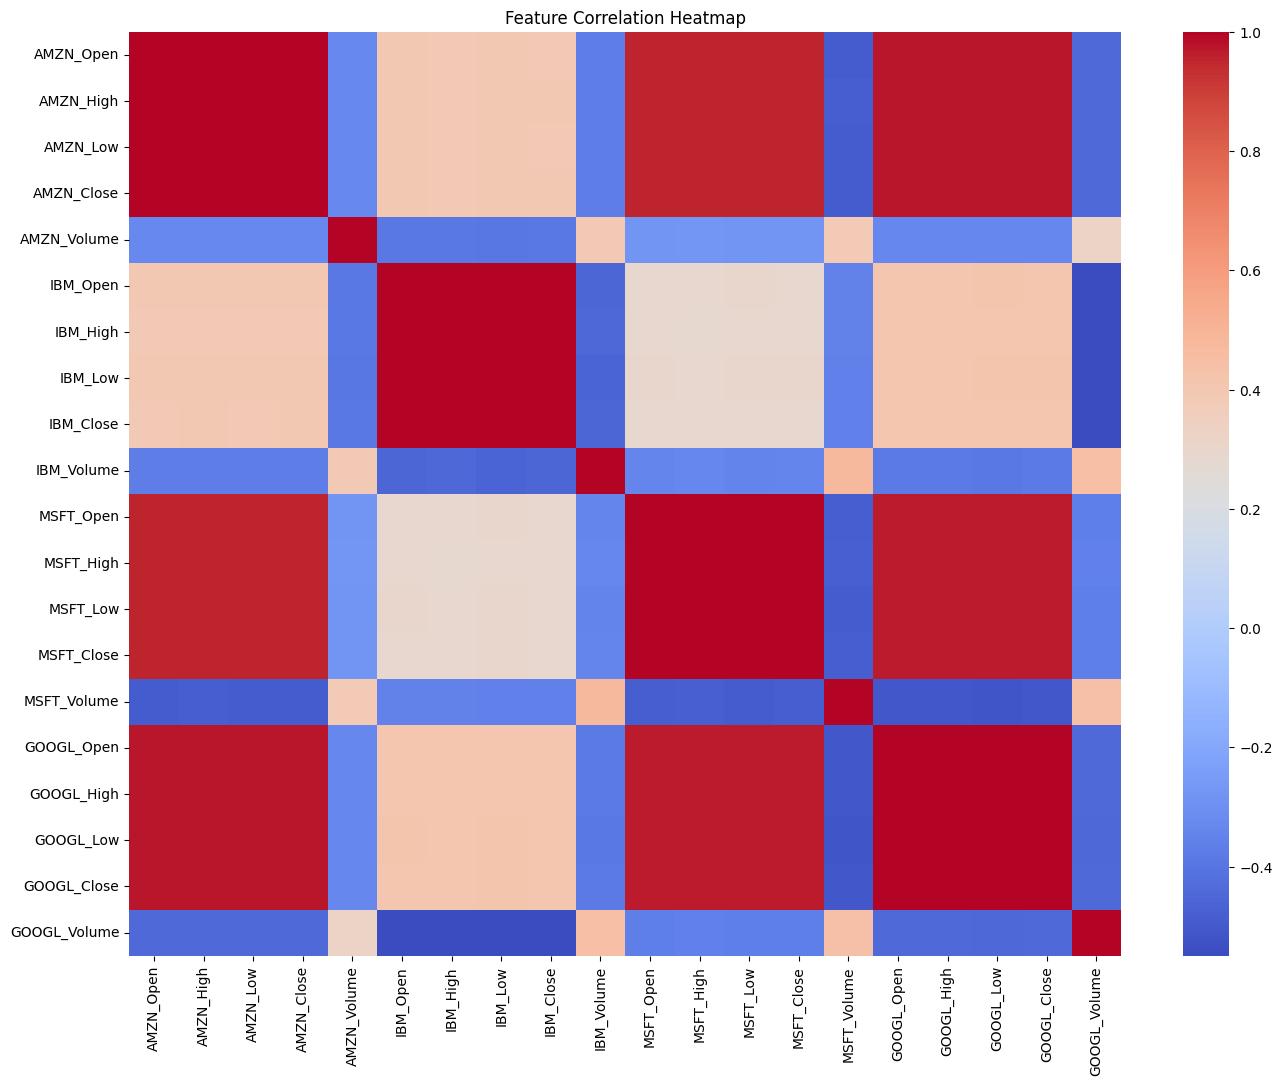

In [16]:
# Analyse correlations
# Exclude 'Date' column since it's not numeric
numeric_df = aggregated_df.drop(columns=['Date'])

# Compute correlation matrix
corr_matrix = numeric_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [19]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windows(df, window_size, step_size, target_cols):
    """
    Creates sliding windows from the data for RNN input.
    
    Args:
        df (pd.DataFrame): Master DataFrame sorted by Date
        window_size (int): Number of time steps per window
        step_size (int): Number of time steps to move the window each iteration
        target_cols (list of str): List of target column names (e.g., ['AMZN_Close', 'GOOGL_Close'])
    
    Returns:
        X (np.ndarray): Input windows of shape (num_windows, window_size, num_features)
        y (np.ndarray): Corresponding target values of shape (num_windows, len(target_cols))
    """
    # Drop 'Date' column for features
    features = df.drop(columns=['Date']).values
    targets = df[target_cols].values
    
    X = []
    y = []
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        X.append(features[start:end])
        y.append(targets[end])  # Target is the value *after* the window
    
    return np.array(X), np.array(y)


# Example target columns
target_cols = ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']

window_size = 30
step_size = 1

X, y = create_windows(aggregated_df, window_size, step_size, target_cols)

print("X shape:", X.shape)  # (num_windows, 30, num_features)
print("y shape:", y.shape)  # (num_windows, 4)


X shape: (2989, 30, 20)
y shape: (2989, 4)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [56]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X_train, X_test):
    """
    Scales windowed feature data (3D arrays) using MinMaxScaler.
    Scaling is done feature-wise based on the training data.
    
    Args:
        X_train (np.ndarray): Training data of shape (num_samples, window_size, num_features)
        X_test (np.ndarray): Testing data of shape (num_samples, window_size, num_features)
        
    Returns:
        X_train_scaled (np.ndarray): Scaled training data, same shape as input
        X_test_scaled (np.ndarray): Scaled testing data, same shape as input
        scalers (list): List of scalers used per feature (for inverse transform if needed)
    """
    num_features = X_train.shape[2]
    scalers = []
    
    # Initialize empty arrays for scaled data with same shape
    X_train_scaled = np.empty_like(X_train)
    X_test_scaled = np.empty_like(X_test)
    
    # Scale each feature separately
    for i in range(num_features):
        scaler = MinMaxScaler()
        
        # Fit scaler on training data feature column (flattened over samples and time)
        feature_train = X_train[:, :, i].reshape(-1, 1)
        scaler.fit(feature_train)
        
        # Transform train and test for that feature
        X_train_scaled[:, :, i] = scaler.transform(X_train[:, :, i])
        X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i])
        
        scalers.append(scaler)
        
    return X_train_scaled, X_test_scaled, scalers



In [52]:
target_cols = ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']
window_size = 30
step_size = 1

X, y = create_windows(aggregated_df, window_size, step_size, target_cols)


In [54]:

# You can do a random split or time-based split (time-based is recommended for stock data)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)  # No shuffling for time series data
X_train_scaled, X_test_scaled, scalers = scale_windowed_data(X_train, X_test)



Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [57]:
# Define a function to create input and output data points from the master DataFrame


def prepare_rnn_data(df, window_size, step_size, target_cols, test_size=0.2):
    """
    Creates windowed data from master DataFrame, splits into train/test, and scales features.

    Args:
        df (pd.DataFrame): Master DataFrame sorted by Date
        window_size (int): Number of time steps in each input window
        step_size (int): Step size (stride) for window sliding
        target_cols (list): List of target column names to predict (e.g. closing prices)
        test_size (float): Fraction of data to use as test set

    Returns:
        X_train_scaled, X_test_scaled: Scaled input windows for training and testing
        y_train, y_test: Target outputs (unscaled)
        scalers: List of scalers for features (to inverse transform if needed)
    """

    # 1. Create windows
    features = df.drop(columns=['Date']).values
    targets = df[target_cols].values

    X = []
    y = []
    for start in range(0, len(df) - window_size, step_size):
        end = start + window_size
        X.append(features[start:end])
        y.append(targets[end])  # target is the step immediately after the window

    X = np.array(X)
    y = np.array(y)

    # 2. Train-test split (no shuffle for time series)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # 3. Scale features per column based on training data
    num_features = X_train.shape[2]
    scalers = []
    X_train_scaled = np.empty_like(X_train)
    X_test_scaled = np.empty_like(X_test)

    for i in range(num_features):
        scaler = MinMaxScaler()
        # Fit on train data (flattened)
        feature_train = X_train[:, :, i].reshape(-1, 1)
        scaler.fit(feature_train)

        X_train_scaled[:, :, i] = scaler.transform(X_train[:, :, i])
        X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i])
        scalers.append(scaler)

    return X_train_scaled, X_test_scaled, y_train, y_test, scalers


In [61]:
num_features = X_train.shape[2]
scalers = []
X_train_scaled = np.empty_like(X_train)
X_test_scaled = np.empty_like(X_test)

for i in range(num_features):
    scaler = MinMaxScaler()
    feature_train = X_train[:, :, i].reshape(-1, 1)
    scaler.fit(feature_train)
    
    X_train_scaled[:, :, i] = scaler.transform(X_train[:, :, i].reshape(-1, 1)).reshape(X_train.shape[0], X_train.shape[1])
    X_test_scaled[:, :, i] = scaler.transform(X_test[:, :, i].reshape(-1, 1)).reshape(X_test.shape[0], X_test.shape[1])
    
    scalers.append(scaler)

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

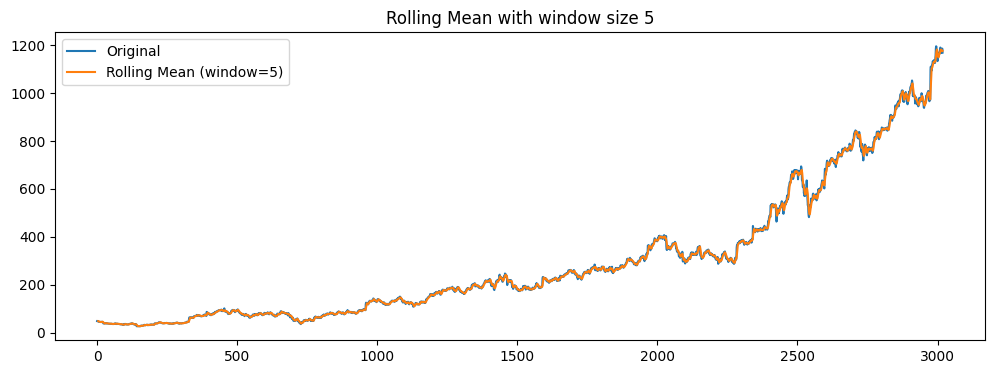

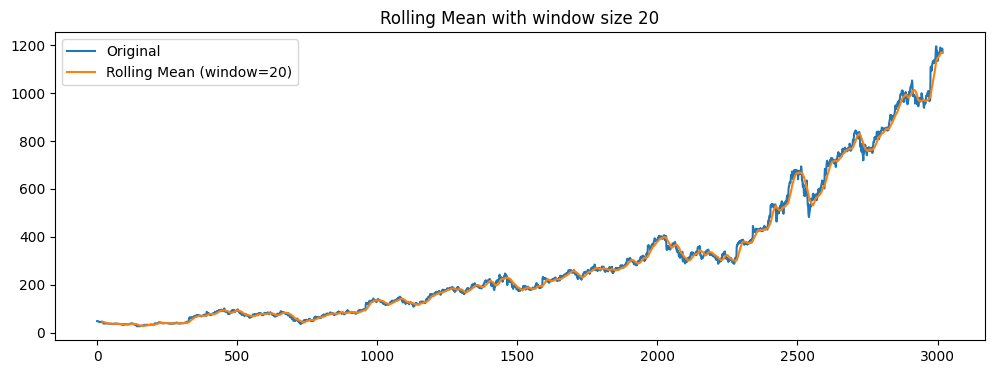

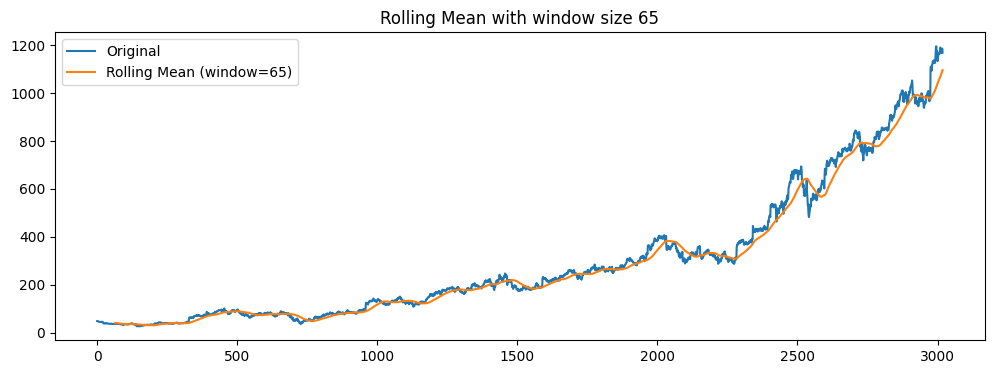

In [68]:
amzn_close = aggregated_df['AMZN_Close']

window_sizes = [5, 20, 65]  # weekly, monthly, quarterly

for window in window_sizes:
    rolling_mean = amzn_close.rolling(window=window).mean()
    plt.figure(figsize=(12, 4))
    plt.plot(amzn_close.index, amzn_close, label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean (window={window})')
    plt.title(f'Rolling Mean with window size {window}')
    plt.legend()
    plt.show()

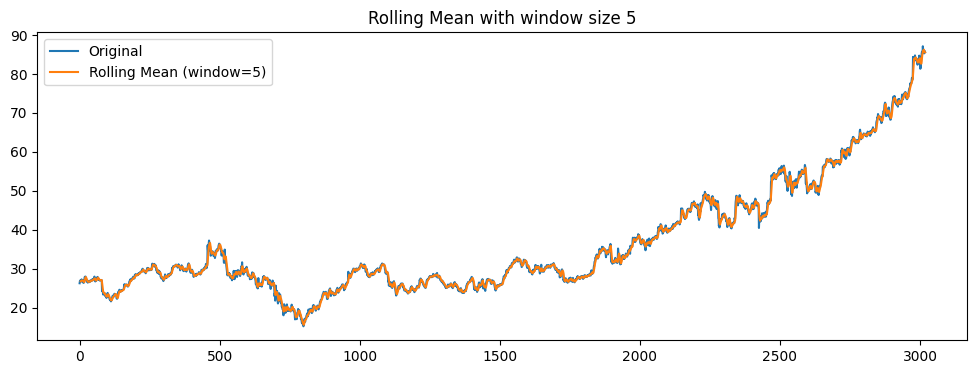

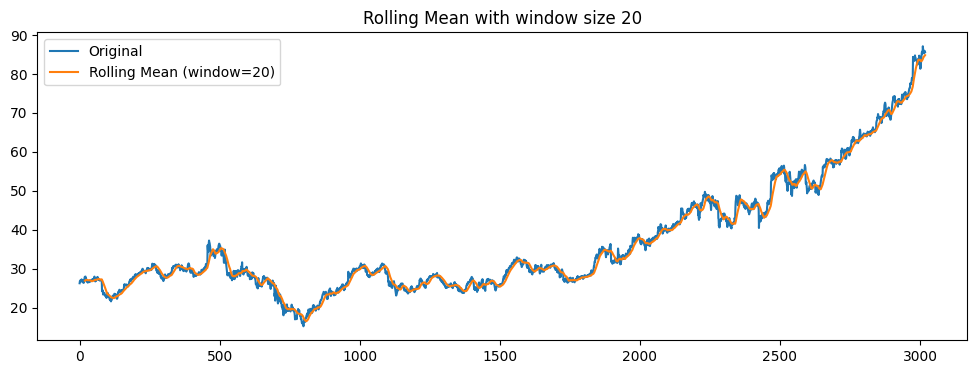

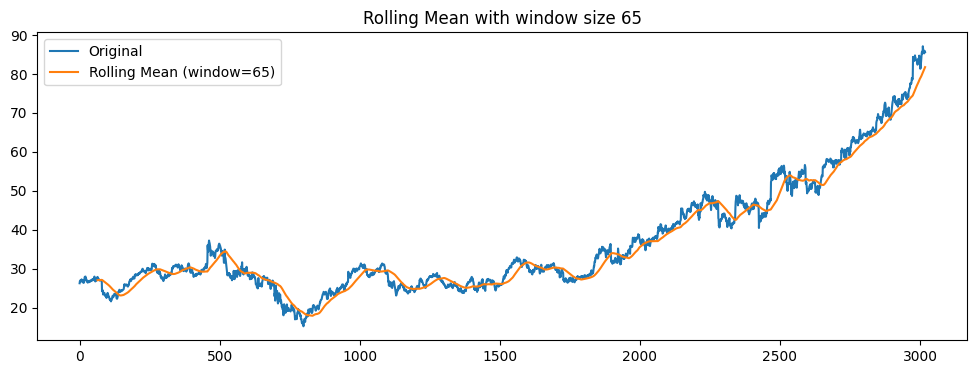

In [97]:
msft_open = aggregated_df['MSFT_Open']

window_sizes = [5, 20, 65]  # weekly, monthly, quarterly

for window in window_sizes:
    rolling_mean = msft_open.rolling(window=window).mean()
    plt.figure(figsize=(12, 4))
    plt.plot(msft_open.index, msft_open, label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean (window={window})')
    plt.title(f'Rolling Mean with window size {window}')
    plt.legend()
    plt.show()

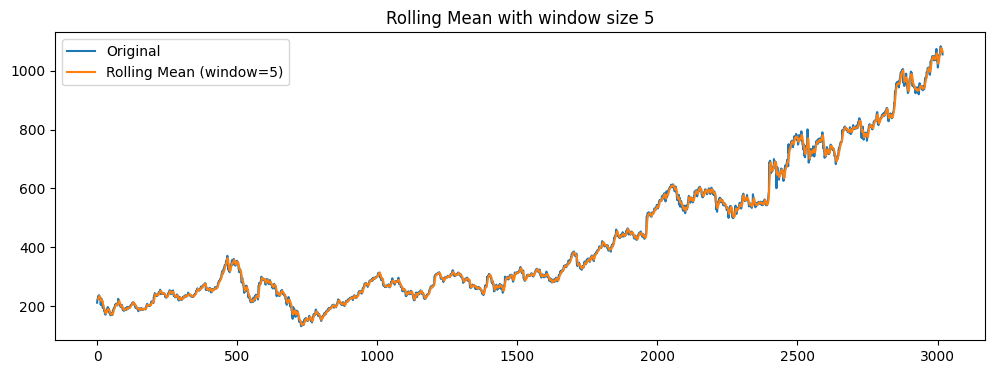

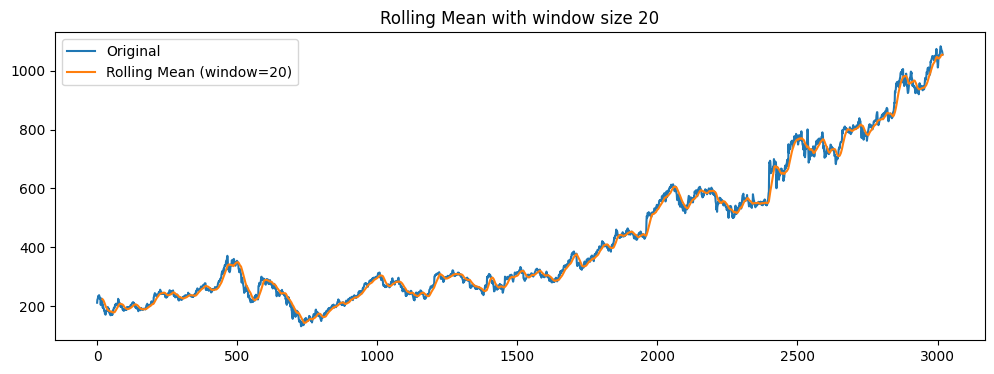

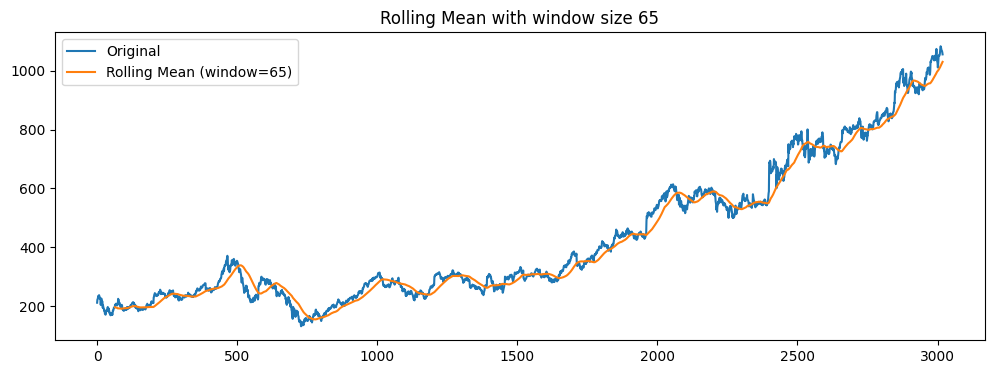

In [98]:
googl_open = aggregated_df['GOOGL_Open']

window_sizes = [5, 20, 65]  # weekly, monthly, quarterly

for window in window_sizes:
    rolling_mean = googl_open.rolling(window=window).mean()
    plt.figure(figsize=(12, 4))
    plt.plot(googl_open.index, googl_open, label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean (window={window})')
    plt.title(f'Rolling Mean with window size {window}')
    plt.legend()
    plt.show()

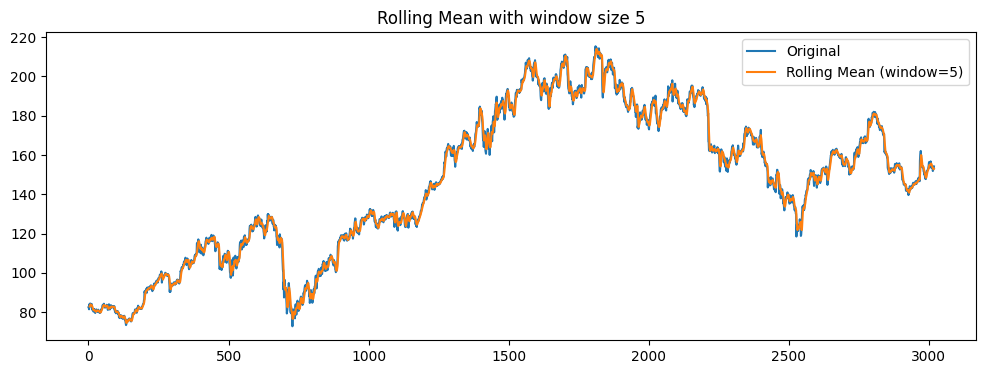

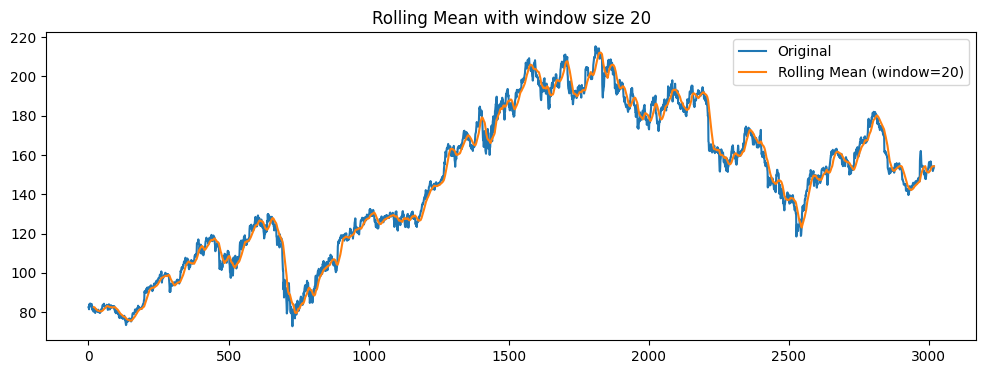

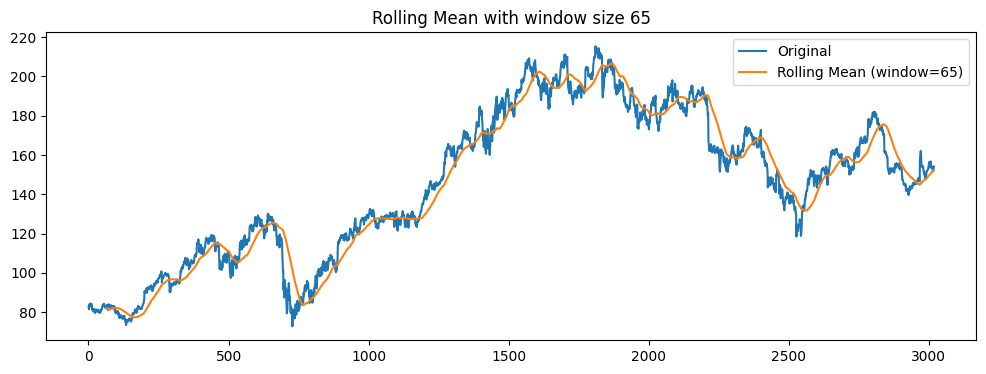

In [99]:
ibm_open = aggregated_df['IBM_Open']

window_sizes = [5, 20, 65]  # weekly, monthly, quarterly

for window in window_sizes:
    rolling_mean = ibm_open.rolling(window=window).mean()
    plt.figure(figsize=(12, 4))
    plt.plot(ibm_open.index, ibm_open, label='Original')
    plt.plot(rolling_mean.index, rolling_mean, label=f'Rolling Mean (window={window})')
    plt.title(f'Rolling Mean with window size {window}')
    plt.legend()
    plt.show()

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [101]:
# Create data instances from the master data frame using decided window size and window stride

# Parameters — adjust based on your analysis
window_size = 30   # e.g., 30 days (about a month)
step_size = 1      # move window forward by 1 day each time
target_cols = ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']

# Create windows
X, y = create_windows(aggregated_df, window_size, step_size, target_cols)

print(f"Input shape (X): {X.shape}")  # Expected: (num_windows, window_size, num_features)
print(f"Target shape (y): {y.shape}")  # Expected: (num_windows, number_of_target_stocks)


Input shape (X): (2989, 30, 20)
Target shape (y): (2989, 4)


In [70]:
# Check the number of data points generated
print("Number of data points (windows) generated:", X.shape[0])


Number of data points (windows) generated: 2989


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [102]:
# Check if the datasets are compatible inputs to neural networks
def check_nn_compatibility(X, y):
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    print(f"X dtype: {X.dtype}")
    print(f"y dtype: {y.dtype}")
    
    print("Checking for NaNs...")
    print(f"Any NaNs in X? {np.isnan(X).any()}")
    print(f"Any NaNs in y? {np.isnan(y).any()}")
    
    if len(X.shape) == 3 and len(y.shape) in [1, 2]:
        print("Shapes are compatible for RNN input and output.")
    else:
        print("Shapes are NOT compatible, please check data preprocessing.")


In [103]:
# Assuming aggregated_df contains columns like 'AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close'

window_size = 30  # example window size (days)
step_size = 1     # move window by 1 day each time

target_cols = ['AMZN_Close', 'GOOGL_Close', 'IBM_Close', 'MSFT_Close']

# Create windowed input-output pairs
X, y = create_windows(aggregated_df, window_size, step_size, target_cols)

# Check if data is compatible for neural network input
check_nn_compatibility(X, y)


X shape: (2989, 30, 20)
y shape: (2989, 4)
X dtype: float64
y dtype: float64
Checking for NaNs...
Any NaNs in X? False
Any NaNs in y? False
Shapes are compatible for RNN input and output.


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [104]:
# Create a function that creates a simple RNN model according to the model configuration arguments
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

def create_simple_rnn_model(input_shape, rnn_units=50, dropout_rate=0.2, output_size=4):
    """
    Creates a simple RNN model for multi-output regression.
    
    Args:
        input_shape (tuple): Shape of input data (time_steps, num_features)
        rnn_units (int): Number of units in the SimpleRNN layer
        dropout_rate (float): Dropout rate between 0 and 1
        output_size (int): Number of output neurons (e.g., number of stocks to predict)
        
    Returns:
        model (tf.keras.Model): Compiled Keras RNN model
    """
    model = Sequential()
    model.add(SimpleRNN(units=rnn_units, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_size))
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return model



In [106]:

# 4. Define input shape and output size for model
input_shape = (X.shape[1], X.shape[2])  # (window_size, num_features)
output_size = y.shape[1]  # 4 targets for 4 stocks

# 5. Create RNN model
model = create_simple_rnn_model(input_shape, rnn_units=50, dropout_rate=0.2, output_size=output_size)

# 6. See model architecture
model.summary()

# Optional: 7. Train the model
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 50)             │         3,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,754 (14.66 KB)

 Trainable params: 3,754 (14.66 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [107]:
# Find an optimal configuration of simple RNN

import numpy as np

# Define hyperparameter grids
units_options = [20, 50, 100]
dropout_options = [0.0, 0.2, 0.5]
batch_sizes = [16, 32]
epochs = 20

best_val_loss = np.inf
best_config = None

for units in units_options:
    for dropout in dropout_options:
        for batch_size in batch_sizes:
            print(f"Training with units={units}, dropout={dropout}, batch_size={batch_size}")

            # Create fresh model for each config
            model = create_simple_rnn_model(
                input_shape=input_shape,
                rnn_units=units,
                dropout_rate=dropout,
                output_size=output_size
            )
            
            # Train with validation split
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                verbose=0
            )
            
            val_loss = history.history['val_loss'][-1]
            print(f"Validation loss: {val_loss:.4f}")

            # Check if best so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = (units, dropout, batch_size)

print(f"Best config: units={best_config[0]}, dropout={best_config[1]}, batch_size={best_config[2]} with val_loss={best_val_loss:.4f}")


Training with units=20, dropout=0.0, batch_size=16
Validation loss: 96334.4609
Training with units=20, dropout=0.0, batch_size=32
Validation loss: 106654.4531
Training with units=20, dropout=0.2, batch_size=16
Validation loss: 95125.4531
Training with units=20, dropout=0.2, batch_size=32
Validation loss: 106564.9609
Training with units=20, dropout=0.5, batch_size=16
Validation loss: 96627.5156
Training with units=20, dropout=0.5, batch_size=32
Validation loss: 107701.1797
Training with units=50, dropout=0.0, batch_size=16
Validation loss: 71560.1328
Training with units=50, dropout=0.0, batch_size=32
Validation loss: 91715.7969
Training with units=50, dropout=0.2, batch_size=16
Validation loss: 73189.6953
Training with units=50, dropout=0.2, batch_size=32
Validation loss: 91966.8672
Training with units=50, dropout=0.5, batch_size=16
Validation loss: 73547.2812
Training with units=50, dropout=0.5, batch_size=32
Validation loss: 91746.3125
Training with units=100, dropout=0.0, batch_size=

In [108]:
# Find the best configuration based on evaluation metrics

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def create_simple_rnn_model(input_shape, units, dropout, output_size):
    model = Sequential()
    model.add(SimpleRNN(units=units, input_shape=input_shape))
    model.add(Dropout(dropout))
    model.add(Dense(output_size))
    model.compile(optimizer=Adam(), loss='mse')
    return model

# Hyperparameter grid
units_options = [20, 50, 100]
dropout_options = [0.0, 0.2, 0.5]
batch_sizes = [16, 32]
epochs = 20

best_val_loss = np.inf
best_config = None
best_model = None

for units in units_options:
    for dropout in dropout_options:
        for batch_size in batch_sizes:
            print(f"Training with units={units}, dropout={dropout}, batch_size={batch_size}")
            model = create_simple_rnn_model(input_shape=(X_train.shape[1], X_train.shape[2]), 
                                           units=units, dropout=dropout, output_size=y_train.shape[1])
            history = model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_split=0.2,
                verbose=0
            )
            val_loss = history.history['val_loss'][-1]
            print(f"Validation loss: {val_loss:.4f}")
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_config = (units, dropout, batch_size)
                best_model = model

print(f"Best config: units={best_config[0]}, dropout={best_config[1]}, batch_size={best_config[2]} with val_loss={best_val_loss:.4f}")

# Optionally evaluate on test data
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test loss: {test_loss:.4f}")



Training with units=20, dropout=0.0, batch_size=16
Validation loss: 96647.7188
Training with units=20, dropout=0.0, batch_size=32
Validation loss: 107995.1094
Training with units=20, dropout=0.2, batch_size=16
Validation loss: 96305.9609
Training with units=20, dropout=0.2, batch_size=32
Validation loss: 107190.4609
Training with units=20, dropout=0.5, batch_size=16
Validation loss: 96450.1406
Training with units=20, dropout=0.5, batch_size=32
Validation loss: 107349.6406
Training with units=50, dropout=0.0, batch_size=16
Validation loss: 72781.3594
Training with units=50, dropout=0.0, batch_size=32
Validation loss: 92554.6406
Training with units=50, dropout=0.2, batch_size=16
Validation loss: 70708.6094
Training with units=50, dropout=0.2, batch_size=32
Validation loss: 92841.5391
Training with units=50, dropout=0.5, batch_size=16
Validation loss: 73853.8828
Training with units=50, dropout=0.5, batch_size=32
Validation loss: 92663.7734
Training with units=100, dropout=0.0, batch_size=

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [117]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Create the final model with the best hyperparameters
final_units = 100
final_dropout = 0.0
final_batch_size = 16
final_epochs = 30  # You can increase epochs for better training

final_model = create_simple_rnn_model(
    input_shape=(X_train.shape[1], X_train.shape[2]),
    units=final_units,
    dropout=final_dropout,
    output_size=y_train.shape[1]
)

# Train the model
history = final_model.fit(
    X_train, y_train,
    epochs=final_epochs,
    batch_size=final_batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate on the test data
test_loss = final_model.evaluate(X_test, y_test)
print(f"Final test loss: {test_loss:.4f}")

# Optionally, save the model for later use
# final_model.save("final_rnn_stock_model.h5")


Plotting the actual vs predicted values

In [112]:
# Predict on the test data and plot

import matplotlib.pyplot as plt

# Predict on test data
y_pred = final_model.predict(X_test)

# Since your targets are scaled, you might want to inverse transform them back to original scale
# Assuming you saved scalers for each output feature during preprocessing:
# e.g., scalers is a list of MinMaxScaler objects for each target column

num_outputs = y_test.shape[1]  # Should be 4 for AMZN, GOOGL, IBM, MSFT

y_test_unscaled = []
y_pred_unscaled = []

for i in range(num_outputs):
    scaler = scalers[i]  # Only pick the scalers used for output columns
    y_test_i = y_test[:, i].reshape(-1, 1)
    y_pred_i = y_pred[:, i].reshape(-1, 1)
    y_test_unscaled.append(scaler.inverse_transform(y_test_i).flatten())
    y_pred_unscaled.append(scaler.inverse_transform(y_pred_i).flatten())

# Plot actual vs predicted for each stock
stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
plt.figure(figsize=(15, 10))

for i in range(len(stock_names)):
    plt.subplot(2, 2, i+1)
    plt.plot(y_test_unscaled[i], label='Actual')
    plt.plot(y_pred_unscaled[i], label='Predicted')
    plt.title(f'Stock price prediction for {stock_names[i]}')
    plt.xlabel('Time (test samples)')
    plt.ylabel('Closing Price')
    plt.legend()

plt.tight_layout()
plt.show()



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [114]:
# Compute the performance of the model on the testing data set
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Evaluate each target (stock) separately
for i, stock in enumerate(stock_names):
    y_true = y_test_unscaled[i]
    y_predicted = y_pred_unscaled[i]

    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_predicted)
    r2 = r2_score(y_true, y_predicted)

    print(f"\n📊 Performance for {stock}:")
    print(f"  - RMSE: {rmse:.2f}")
    print(f"  - MAE:  {mae:.2f}")
    print(f"  - R² Score: {r2:.4f}")


📊 Performance for AMZN:
  - RMSE: 357278.95
  - MAE:  343024.98
  - R² Score: -12.0531

📊 Performance for GOOGL:
  - RMSE: 302020.64
  - MAE:  295066.85
  - R² Score: -22.5305

📊 Performance for IBM:
  - RMSE: 9189.77
  - MAE:  6951.05
  - R² Score: -1.1267

📊 Performance for MSFT:
  - RMSE: 16751.73
  - MAE:  15817.08
  - R² Score: -8.3094


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [136]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def build_advanced_rnn_model(
    input_shape,
    rnn_type='LSTM',                  # 'SimpleRNN', 'LSTM', 'GRU'
    num_layers=2,
    units=64,
    dropout_rate=0.2,
    dense_units=[64, 1],
    optimizer_type='adam',
    learning_rate=0.001,
    loss='mse'
):
    model = Sequential()

    # Choose RNN cell type
    RNNLayer = {'SimpleRNN': SimpleRNN, 'LSTM': LSTM, 'GRU': GRU}[rnn_type]

    # First RNN layer with input shape
    model.add(RNNLayer(units, return_sequences=(num_layers > 1), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    # Additional RNN layers (if any)
    for i in range(1, num_layers):
        # return_sequences=True only if not last layer
        return_seq = (i < num_layers - 1)
        model.add(RNNLayer(units, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))

    # Dense layers
    for du in dense_units:
        model.add(Dense(du, activation='relu' if du != 1 else 'linear'))

    # Optimizer
    optimizer = {
        'adam': Adam(learning_rate),
        'rmsprop': RMSprop(learning_rate),
        'sgd': SGD(learning_rate)
    }[optimizer_type]

    model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    return model


In [137]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)

model = build_advanced_rnn_model(
    input_shape=input_shape,
    rnn_type='LSTM',
    num_layers=3,
    units=100,
    dropout_rate=0.3,
    dense_units=[64, 1],
    optimizer_type='adam',
    learning_rate=0.001,
    loss='mse'
)

model.summary()


/Users/shristibisht/.pyenv/versions/waste_env310/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 100)        │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 100)        │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 215,729 (842.69 KB)

 Trainable params: 215,729 (842.69 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [140]:
# Find an optimal configuration

import keras_tuner as kt

def build_model(hp):
    input_shape = (X_train.shape[1], X_train.shape[2])

    rnn_type = hp.Choice('rnn_type', ['SimpleRNN', 'LSTM', 'GRU'])
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    num_layers = hp.Int('num_layers', 1, 3)
    dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    dense_units = hp.Choice('dense_units', [32, 64, 128])

    RNNLayer = {'SimpleRNN': SimpleRNN, 'LSTM': LSTM, 'GRU': GRU}[rnn_type]

    model = Sequential()
    model.add(RNNLayer(units, return_sequences=(num_layers > 1), input_shape=input_shape))
    model.add(Dropout(dropout_rate))

    for i in range(1, num_layers):
        return_seq = (i < num_layers - 1)
        model.add(RNNLayer(units, return_sequences=return_seq))
        model.add(Dropout(dropout_rate))

    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model


In [141]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='rnn_tuning',
    project_name='stock_rnn'
)


In [142]:
tuner.search(
    X_train, y_train,
    epochs=20,
    validation_split=0.2,
    batch_size=32,
    verbose=1
)


Trial 20 Complete [00h 01m 10s]
val_loss: 33724.79296875

Best val_loss So Far: 25443.8515625
Total elapsed time: 00h 12m 00s


In [143]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters Found:")
for hp in best_hps.values:
    print(f"{hp}: {best_hps.get(hp)}")


Best Hyperparameters Found:
rnn_type: SimpleRNN
units: 32
num_layers: 3
dropout_rate: 0.0
learning_rate: 0.003982481621996575
dense_units: 32


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [148]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
import tensorflow as tf

def build_final_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(X_train.shape[1], X_train.shape[2])))

    for _ in range(3):  # num_layers
        model.add(tf.keras.layers.SimpleRNN(32, return_sequences=True))  # units
    model.add(tf.keras.layers.SimpleRNN(32))  # final RNN layer without return_sequences

    model.add(tf.keras.layers.Dense(32, activation='relu'))  # dense_units
    model.add(tf.keras.layers.Dense(y_train.shape[1]))  # output layer

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.003982481621996575)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model


In [149]:
final_model = build_final_model()
history = final_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 29011.5332 - mae: 135.6216 - val_loss: 94382.5859 - val_mae: 239.9390
Epoch 2/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 14664.1357 - mae: 85.9708 - val_loss: 49415.2812 - val_mae: 161.5716
Epoch 3/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4478.9106 - mae: 47.6895 - val_loss: 36967.4414 - val_mae: 144.4119
Epoch 4/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3251.0061 - mae: 40.9869 - val_loss: 34697.9023 - val_mae: 140.9866
Epoch 5/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3147.3640 - mae: 40.5491 - val_loss: 35295.8750 - val_mae: 142.7524
Epoch 6/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3138.1206 - mae: 40.0933 - val_loss: 34268.6406 - val_mae: 140.1454
Epoch 7/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3286.5203 - mae: 41.3257 - val_loss: 34678.3516 - val_mae: 140.8111
Epoch 8/30
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3203.2913 - mae: 40.7090 - val_loss: 35340.5859 -

Plotting the actual vs predicted values

In [162]:
# Predict on the test data and plot

import matplotlib.pyplot as plt

# Predict on test data
y_pred = final_model.predict(X_test)

# Since your targets are scaled, you might want to inverse transform them back to original scale
# Assuming you saved scalers for each output feature during preprocessing:
# e.g., scalers is a list of MinMaxScaler objects for each target column

num_outputs = y_test.shape[1]  # Should be 4 for AMZN, GOOGL, IBM, MSFT

y_test_unscaled = []
y_pred_unscaled = []

for i in range(num_outputs):
    scaler = scalers[i]  # Only pick the scalers used for output columns
    y_test_i = y_test[:, i].reshape(-1, 1)
    y_pred_i = y_pred[:, i].reshape(-1, 1)
    y_test_unscaled.append(scaler.inverse_transform(y_test_i).flatten())
    y_pred_unscaled.append(scaler.inverse_transform(y_pred_i).flatten())

stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

for i, stock in enumerate(stock_names):
    rmse = np.sqrt(mean_squared_error(y_test_unscaled[i], y_pred_unscaled[i]))
    mae = mean_absolute_error(y_test_unscaled[i], y_pred_unscaled[i])
    r2 = r2_score(y_test_unscaled[i], y_pred_unscaled[i])
    print(f"Performance for {stock}:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAE: {mae:.2f}")
    print(f"  R² Score: {r2:.4f}")
    print()



19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Performance for AMZN:
  RMSE: 406474.95
  MAE: 393450.04
  R² Score: -15.8954

Performance for GOOGL:
  RMSE: 354856.90
  MAE: 348168.04
  R² Score: -31.4836

Performance for IBM:
  RMSE: 30527.55
  MAE: 28835.49
  R² Score: -22.4685

Performance for MSFT:
  RMSE: 21446.94
  MAE: 20619.38
  R² Score: -14.2592



## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [83]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [84]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [85]:
# Find an optimal configuration of simple RNN



In [86]:
# Find the best configuration



In [87]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [88]:
# Compute the performance of the model on the testing data set



In [89]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [90]:
# Find an optimal configuration of advanced RNN



In [91]:
# Find the best configuration



In [92]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [93]:
# Compute the performance of the model on the testing data set



In [94]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

In [ ]:
1.  Microsoft and Amazon had the strongest correlation of daily stock return. It's also interesting to see that all the technology comapnies are positively correlated.
